In [206]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, lit, concat
spark = SparkSession.builder.master("local[1]") \
                    .appName('Schawrz_task') \
                    .getOrCreate()


In [207]:
bikesharesDf = spark.read.csv('./data/sample.csv', header=True)

In [208]:
transformed_bikesharesDf = bikesharesDf.withColumn('date', split(bikesharesDf['starttime'], ' ').getItem(0))

In [209]:
final_bikesharesDf = transformed_bikesharesDf.withColumn('year', split(transformed_bikesharesDf['date'], '/').getItem(2))\
.withColumn('day', split(transformed_bikesharesDf['date'], '/').getItem(1))\
.withColumn('month', split(transformed_bikesharesDf['date'], '/').getItem(0)).drop('date')\
.withColumnRenamed('start station name', 'start_station_name')\
.withColumnRenamed('end station name',  'end_station_name')\
.withColumnRenamed('birth year', 'birth_year')\
.withColumn('date_for_join', concat(col('day'), lit('-'), ('month'), lit('-'), col('year'))).drop(col('month')).drop(col('day'))


In [210]:
weatherDf = spark.read.csv('./data/weather_data_nyc_2016.csv', header=True)

weatherDf = weatherDf.withColumnRenamed('maximum temperature', 'maximum_temperature')\
.withColumnRenamed( 'minimum temperature', 'minimum_temperature')\
.withColumnRenamed('average temperature', 'average_temperature')\
.withColumnRenamed('snow fall', 'snow_fall')\
.withColumnRenamed('snow depth', 'snow_depth')


In [211]:
bikeshares_wheaterDf = final_bikesharesDf.join(weatherDf, final_bikesharesDf['date_for_join'] == weatherDf['date'], 'inner')

In [212]:
bikeshares_wheaterDf_final = bikeshares_wheaterDf.select( 'tripduration', 
                                                        'start_station_name', 
                                                        'end_station_name',
                                                        'usertype',
                                                        'birth_year',
                                                        'gender',
                                                        'date',
                                                        'maximum_temperature',
                                                        'minimum_temperature',
                                                        'average_temperature',
                                                        'precipitation',
                                                        'snow_fall',
                                                        'snow_depth')

In [213]:
flag = "NOK!"
if  bikeshares_wheaterDf_final.count()  == final_bikesharesDf.count():
    flag ="OK!"

if flag != "OK!":
    raise Exception("Somethings is wrong with DFs")

In [214]:
from pyspark.sql.types import StructType, StructField, StringType,  FloatType, IntegerType

schema = StructType([
    StructField('tripduration', IntegerType()),
    StructField('start_station_name', StringType()),
    StructField('end_station_name', StringType()),
    StructField('user_type', StringType()),
    StructField('birthyear', IntegerType()),
    StructField('gender', IntegerType()),
    StructField('date', StringType()),
    StructField('maximum_temperature', FloatType()),
    StructField('minimum_temperature', FloatType()),
    StructField('average_temperature', FloatType()),
    StructField('precipitation', FloatType()),
    StructField('snow_fall', FloatType()),
    StructField('snow_depth', FloatType()),
])

In [215]:
bikeshares_wheaterDf_final.write.mode('overwrite').csv('./data/result_csv')

In [216]:
bikeshares_wheater_analyticsDf = spark.read.csv('./data/result_csv', schema=schema, header=True)

In [248]:
bikeshares_wheater_analyticsDf.write.mode('overwrite').parquet('./data/result_final_parquet')

analyticsDf = spark.read.parquet('./data/result_final_parquet')

analyticsDf = analyticsDf.filter(col('tripduration') < 5000 )

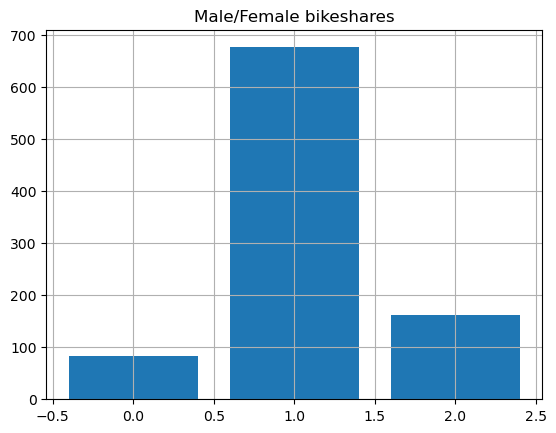

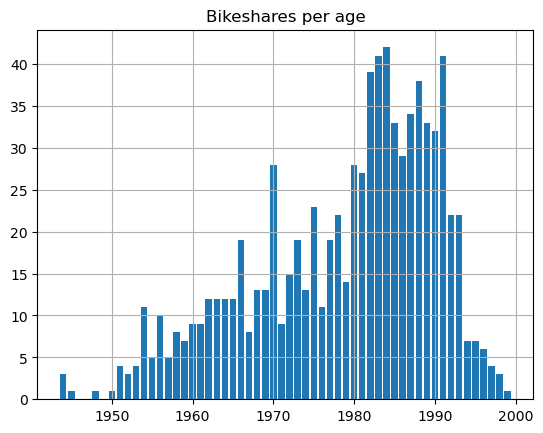

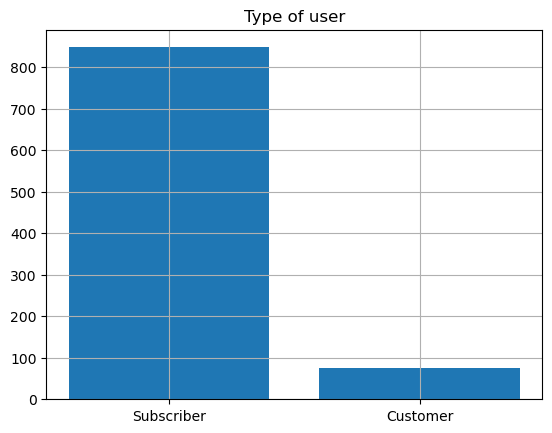

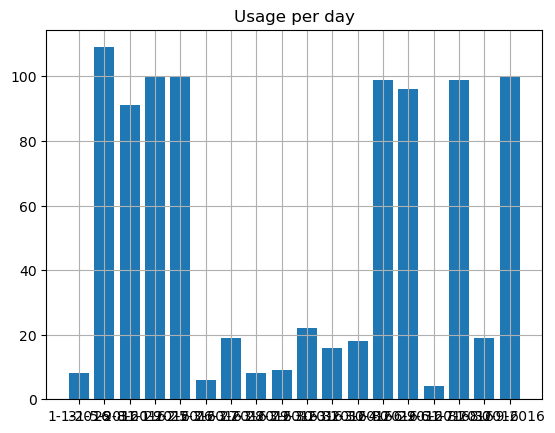

In [280]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as f
from collections import Counter

'''
 0 --> unknown
 1 --> male
 2 --> female
'''

def prepare_for_bar(column, title):
    xpoint = analyticsDf.select(f.collect_list(column)).first()[0]
    x = Counter(xpoint).keys()
    y = Counter(xpoint).values()

    
    plt.title(title)
    plt.grid()
    plt.bar(x, y)
    plt.show()
    lt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')

prepare_for_bar('gender', 'Male/Female bikeshares')

prepare_for_bar('birthyear', 'Bikeshares per age')

prepare_for_bar('user_type', 'Type of user')

prepare_for_bar('date', 'Usage per day')


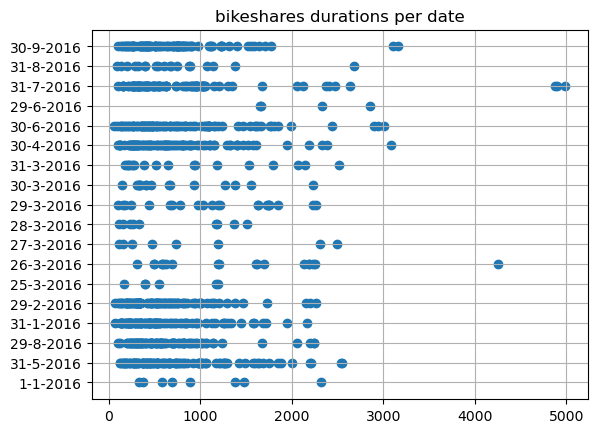

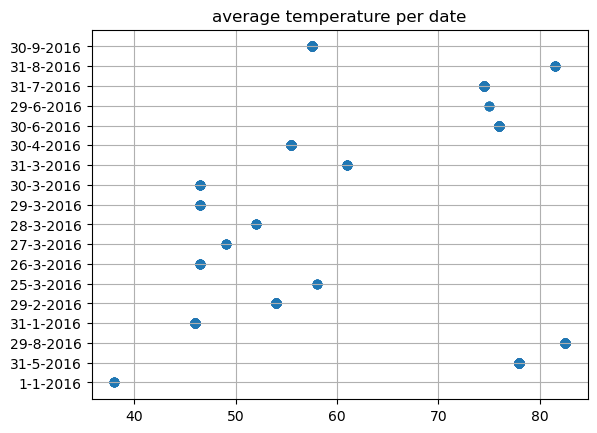

In [276]:

avg_temp = analyticsDf.select(f.collect_list('average_temperature')).first()[0]
tripdur = analyticsDf.select(f.collect_list('tripduration')).first()[0]
date = analyticsDf.select(f.collect_list('date')).first()[0]

plt.title('bikeshares durations per date')
plt.scatter(tripdur, date)
plt.grid()
plt.show()
plt.title('average temperature per date')
plt.grid()
plt.scatter(avg_temp,date) 
plt.show()



(array([117., 191., 106.,  19.,  17.,  38.,  18., 195., 103., 119.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

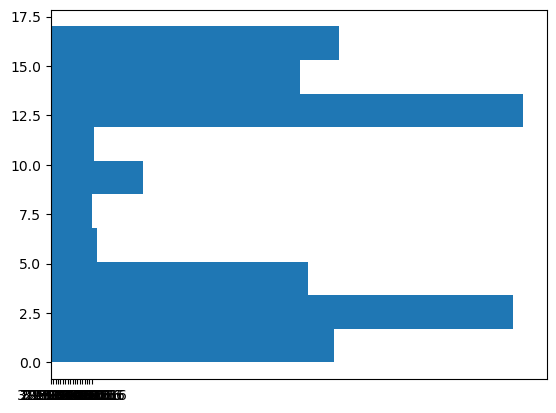

In [279]:

date = analyticsDf.select(f.collect_list('date')).first()[0]


plt.hist(date, orientation='horizontal')
